# Netflix shows analysis
--- 

The given dataset consists of Shows and Movies from the year 1940 to 2017, available on
Netflix, a worldwide popular video-streaming application. Shows rated from “_G_”(General
Audiences) to “_R_”(strong violence, sexual content and adult language) are all included, attracting
a wide-range of audience. Details included about each show are rating, rating description, rating
level, release year, user rating score, user rating score, user rating size.

Average user rating score(out of 100) is 84 where ‘**13 reasons why**’ scores the highest rating of
99 and ‘**Life Unexpected**’ and ‘**Curious George**’ equally scoring 55, the lowest rated shows by
users in the list.

### Problems found in the dataset
There are several missing values in some of the rows. Few rows are repeated. Details regarding Genre are not
provided making it difficult to categorize the shows according to these values. A couple of
column names are misplaced.

### Solutions implemented
* Basic data cleaning(remove repeating rows).
* Add additional columns(Age restriction, genre)
* Fill in missing values in rows based on most generic values given(missing rating
  description based on most used description for each rating).

### Things to Analyse
* Trending genre for movies each decade based on show genre.
* Trending rating for shows and movies in each decade.
* What is common among high rated shows/movies?
* Do popular shows or movies have mature content?
* Ratio of popularity for general vs Age restricted movies all together. 

## Essential Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import numpy as np
import time
from bs4 import BeautifulSoup
import requests
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

In [2]:
import warnings

warnings.filterwarnings('ignore')

## Read the file

In [3]:
nf = pd.read_csv('../input/netflix-shows/Netflix Shows.csv', encoding='latin-1')
nf.head(10)

,title,rating,ratingLevel,ratingDescription,release year,user rating score,user rating size
0,White Chicks,PG-13,"crude and sexual humor, language and some drug...",80,2004,82.0,80
1,Lucky Number Slevin,R,"strong violence, sexual content and adult lang...",100,2006,NaN,82
2,Grey's Anatomy,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,98.0,80
3,Prison Break,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2008,98.0,80
4,How I Met Your Mother,TV-PG,Parental guidance suggested. May not be suitab...,70,2014,94.0,80
5,Supernatural,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,95.0,80
6,Breaking Bad,TV-MA,For mature audiences. May not be suitable for...,110,2013,97.0,80
7,The Vampire Diaries,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2017,91.0,80
8,The Walking Dead,TV-MA,For mature audiences. May not be suitable for...,110,2015,98.0,80
9,Pretty Little Liars,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,96.0,80


## Drop duplicate rows

In [4]:
df = nf.drop_duplicates() 
df

,title,rating,ratingLevel,ratingDescription,release year,user rating score,user rating size
0,White Chicks,PG-13,"crude and sexual humor, language and some drug...",80,2004,82.0,80
1,Lucky Number Slevin,R,"strong violence, sexual content and adult lang...",100,2006,NaN,82
2,Grey's Anatomy,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,98.0,80
3,Prison Break,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2008,98.0,80
4,How I Met Your Mother,TV-PG,Parental guidance suggested. May not be suitab...,70,2014,94.0,80
...,...,...,...,...,...,...,...
989,Russell Madness,PG,some rude humor and sports action,60,2015,NaN,82
993,Wiener Dog Internationals,G,General Audiences. Suitable for all ages.,35,2015,NaN,82
994,Pup Star,G,General Audiences. Suitable for all ages.,35,2016,NaN,82
997,Precious Puppies,TV-G,Suitable for all ages.,35,2003,NaN,82


## Rename columns

The original dataset seems to have misplaced a couple of column names. Since there isn't much information available about it, I thought of renaming these columns for better understanding.

In [5]:
df.rename(columns = {'ratingLevel':'ratingDescription','ratingDescription':'ratingLevel' }, inplace = True)  

In [6]:
df = df.set_index(np.arange(0,500))

## Describing the DataFrame

In [7]:
df.describe()

,ratingLevel,release year,user rating score,user rating size
count,500.000000,500.000000,256.000000,500.000000
mean,68.754000,2010.976000,81.398438,80.972000
std,31.505089,7.829305,12.730904,0.998604
min,10.000000,1940.000000,55.000000,80.000000
25%,41.000000,2009.000000,71.000000,80.000000
50%,70.000000,2014.000000,83.500000,80.000000
75%,90.000000,2016.000000,93.000000,82.000000
max,124.000000,2017.000000,99.000000,82.000000


In [8]:
df['ratingDescription'].fillna("Not_Filled", inplace=True) 

## Frequency of each rating from the column 'rating'

In [9]:
Rating_Count = (df["rating"].value_counts()).sort_index()
Rating_Count

G            53
NR           10
PG           76
PG-13        12
R            14
TV-14       106
TV-G         29
TV-MA        82
TV-PG        33
TV-Y         36
TV-Y7        23
TV-Y7-FV     25
UR            1
Name: rating, dtype: int64

## Fill in missing data

There were several missing rows in 'ratingDescription' column. So I decided to fill in the missing description values with the most generic description present in the column.

In [10]:
Ser = []

for i in Rating_Count.index:   #iterate through Rating_Count
    df_i = df.where(df['rating'] == i) #new dataframe is created where rating value is same as i. Example : new dataframe where rating == 'G'
    max_val = (df_i["ratingDescription"].value_counts()).sort_index() #list of rating description values along with their counts
    Ser.append(max_val.index[max_val.values == max_val.max()][0]) # get max occuring description and append to a list
    
Ser

['General Audiences. Suitable for all ages.',
 'This movie has not been rated.',
 'Parental guidance suggested. May not be suitable for children.',
 'For some rude and suggestive material, and for language.',
 'Restricted. May be inappropriate for children 17 and under.',
 'Parents strongly cautioned. May be unsuitable for children ages 14 and under.',
 'Suitable for all ages.',
 'For mature audiences.  May not be suitable for children 17 and under.',
 'Parental guidance suggested. May not be suitable for all children.',
 'Suitable for all ages.',
 'Suitable for children ages 7 and older',
 'Suitable for children ages 7 and older.  Content contains fantasy violence.',
 'This movie has not been rated. Intended for adults only and may contain sex, violence, drugs, language or other adult themes.']

## Create a Data Frame out of the resultant values.

In [11]:
new_df = pd.DataFrame({'rating': Rating_Count.index, 'Max_found_description': Ser}) #created new dataframe for maximun description occurence
new_df

,rating,Max_found_description
0,G,General Audiences. Suitable for all ages.
1,NR,This movie has not been rated.
2,PG,Parental guidance suggested. May not be suitab...
3,PG-13,"For some rude and suggestive material, and for..."
4,R,Restricted. May be inappropriate for children ...
5,TV-14,Parents strongly cautioned. May be unsuitable ...
6,TV-G,Suitable for all ages.
7,TV-MA,For mature audiences. May not be suitable for...
8,TV-PG,Parental guidance suggested. May not be suitab...
9,TV-Y,Suitable for all ages.


## Fill in the missing values in 'ratingDescription' with corresponding values in 'Max_found_description' column for each rating

In [12]:
for i in range(len(df.index)):
    if 'Not_Filled' in df['ratingDescription'][i]:
        rating = df['rating'][i]
        description = new_df.loc[new_df['rating'] == rating, 'Max_found_description'].values[0]
        df['ratingDescription'][i] = description
        

The missing values in 'ratingDescription' are now filled.

In [13]:
df[:10]

,title,rating,ratingDescription,ratingLevel,release year,user rating score,user rating size
0,White Chicks,PG-13,"crude and sexual humor, language and some drug...",80,2004,82.0,80
1,Lucky Number Slevin,R,"strong violence, sexual content and adult lang...",100,2006,NaN,82
2,Grey's Anatomy,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,98.0,80
3,Prison Break,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2008,98.0,80
4,How I Met Your Mother,TV-PG,Parental guidance suggested. May not be suitab...,70,2014,94.0,80
5,Supernatural,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,95.0,80
6,Breaking Bad,TV-MA,For mature audiences. May not be suitable for...,110,2013,97.0,80
7,The Vampire Diaries,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2017,91.0,80
8,The Walking Dead,TV-MA,For mature audiences. May not be suitable for...,110,2015,98.0,80
9,Pretty Little Liars,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,96.0,80


## Adding new information regarding genre of each show/movie through web scraping

Since there was no genre related information in the dataset, I've come up with a script that pulls data from [wikipedia](https://www.wikipedia.org/) and [rotten-tomatoes](https://www.rottentomatoes.com/) websites, which then I'm using it to find out trends. I have used 'BeautifulSoup',a library used for web scraping.



The function below pulls genre from wikipedia and returns a list of genres available for the corresponding shows/movies in the Data Frame.

In [14]:
def get_genre(lst_val): #gets genre from wikipedia : returns a List
    url = "https://en.wikipedia.org/wiki/" + lst_val #last_val is the title of show/movie
    page = requests.get(url) 
    soup = BeautifulSoup(page.content, 'html.parser')
    capi = soup.find_all("td",class_="category")
    fill_val = [re.sub(r"\[\d+\]", "", i.get_text().strip().replace("\n",", ")) for i in capi]
    return fill_val

The function below pulls genre from 'rotten-tomatoes' and returns a Series of information available for the corresponding shows/movies in the Data Frame.

In [15]:
def get_info_rt(url_val): #gets details from rotten tomatoes : returns a Series
    url_mov ="m/"
    url_tv = "tv/"
    url = "https://www.rottentomatoes.com/"

    page = requests.get(url + url_mov + url_val)
    soup = BeautifulSoup(page.content, 'html.parser')

    capi = soup.select("ul.content-meta.info li")
    fill_val = [i.find(class_="meta-value").get_text().replace("\n","").strip().replace("and",",").replace(" ","") for i in capi] 
    fill_lbl = [i.find(class_="meta-label").get_text().replace("\n","").strip(":").replace("and",",").replace(" ","") for i in capi] 
    final_ser = pd.Series(fill_val,index=fill_lbl)
    
    if(len(final_ser) <= 1):
        page = requests.get(url + url_tv + url_val)
        soup = BeautifulSoup(page.content, 'html.parser')

        cont = soup.select("div.panel-body.content_body td")
        fill_lbl = [i.get_text().replace(" \n","").strip(": \n").replace(" ","") for i in cont][::2]
        fill_val = [i.get_text().replace(" \n","").strip(": \n").replace(" ","") for i in cont][1::2]
        final_ser = pd.Series(fill_val,index=fill_lbl)
        return final_ser

    return final_ser

The script below gets genre of each show/movie if available in the websites. the values are stored in a new column 'Genre' 

In [16]:
#Script to pull Genre from wikipedia and rotten tomatoes
t1 = time.time()

df['Genre'] = "not found"
list_titles =  [i.strip().replace(" ","_") for i in df['title']]

#If a particular title doesnt work, try appending the values below to the title 
change_titles = ['_(TV_series)','_(American_TV_series)','_(franchise)']

#since many shows had title tracks with the same name, results were of the song instead of the tv show/movie. 
# Hence to avoid them.
songs_to_avoid = "alternative rock ska pop funk hip hop electronic film score jazz classical orchestra country feature film soundtrack hindi"


for i in range(len(df.index[:])):
        wiki_status = 0
        #print(i)
        fill_val = get_genre(list_titles[i])
        

        if len(fill_val) > 0: 
            test_val = fill_val[0].lower().split(",",1)[0]

            x = test_val.strip() not in songs_to_avoid

            if x:
                wiki_status = 1
                df['Genre'][i] = " ".join(fill_val)
                continue
            
        for j in change_titles:
            changed_title = list_titles[i] + j
            fill_val2 = get_genre(changed_title)
            

            if len(fill_val2) > 0:
                wiki_status = 1
                df['Genre'][i] = " ".join(fill_val2) 
                break

        if wiki_status == 0 :
            value_change = list_titles[i].lower()
            from_rt = get_info_rt(value_change)
            if len(from_rt)>0:
                df['Genre'][i] = from_rt.get(key = 'Genre')
                
            else:
                year = str(df['release year'][i])
                value_change2 = value_change + "_" + year
                from_rt2 = get_info_rt(value_change2)
                df['Genre'][i] = from_rt2.get(key = 'Genre')
                
            
t2= time.time()
time_ = t2-t1
print("Done in seconds : ",time_)

Done in seconds :  1525.684118270874


Rating description mentions the minimum agefor a viewer for each show/movie which can be denotedin a seperate column 

In [17]:
#Create additionl column for age restricted details

df['Age Restriction'] = "None"
for i in range(len(df['ratingDescription'])):
    num = " ".join(re.findall(r'[0-9]+', df['ratingDescription'][i]))
    if num:
        df['Age Restriction'][i] =num + "+" 
    else:
        df['Age Restriction'][i] = "" 

In [18]:
df[:10]

,title,rating,ratingDescription,ratingLevel,release year,user rating score,user rating size,Genre,Age Restriction
0,White Chicks,PG-13,"crude and sexual humor, language and some drug...",80,2004,82.0,80,comedy,
1,Lucky Number Slevin,R,"strong violence, sexual content and adult lang...",100,2006,NaN,82,"mystery,thriller,crime,drama",
2,Grey's Anatomy,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,98.0,80,"Medical drama, Romantic drama, Comedy-drama, E...",14+
3,Prison Break,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2008,98.0,80,Serial dramaCrime dramaAction thriller,14+
4,How I Met Your Mother,TV-PG,Parental guidance suggested. May not be suitab...,70,2014,94.0,80,"Sitcom, Romantic comedy",
5,Supernatural,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,95.0,80,"Action, Adventure, Drama, Fantasy, Horror, Mys...",14+
6,Breaking Bad,TV-MA,For mature audiences. May not be suitable for...,110,2013,97.0,80,"Serial drama, Crime drama, Thriller, Neo-Weste...",17+
7,The Vampire Diaries,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2017,91.0,80,"Drama, Supernatural, Horror, Fantasy",14+
8,The Walking Dead,TV-MA,For mature audiences. May not be suitable for...,110,2015,98.0,80,"Horror, Neo-Western, Serial drama, Zombie apoc...",17+
9,Pretty Little Liars,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,96.0,80,"Crime thriller, Mystery, Teen drama",14+


In [19]:
df.to_csv('netflix_shows_with_genre.csv', index=True) 

In [20]:
df2 = pd.read_csv('./netflix_shows_with_genre.csv', encoding='UTF-8')
df2.head(10)

,Unnamed: 0,title,rating,ratingDescription,ratingLevel,release year,user rating score,user rating size,Genre,Age Restriction
0,0,White Chicks,PG-13,"crude and sexual humor, language and some drug...",80,2004,82.0,80,comedy,NaN
1,1,Lucky Number Slevin,R,"strong violence, sexual content and adult lang...",100,2006,NaN,82,"mystery,thriller,crime,drama",NaN
2,2,Grey's Anatomy,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,98.0,80,"Medical drama, Romantic drama, Comedy-drama, E...",14+
3,3,Prison Break,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2008,98.0,80,Serial dramaCrime dramaAction thriller,14+
4,4,How I Met Your Mother,TV-PG,Parental guidance suggested. May not be suitab...,70,2014,94.0,80,"Sitcom, Romantic comedy",NaN
5,5,Supernatural,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,95.0,80,"Action, Adventure, Drama, Fantasy, Horror, Mys...",14+
6,6,Breaking Bad,TV-MA,For mature audiences. May not be suitable for...,110,2013,97.0,80,"Serial drama, Crime drama, Thriller, Neo-Weste...",17+
7,7,The Vampire Diaries,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2017,91.0,80,"Drama, Supernatural, Horror, Fantasy",14+
8,8,The Walking Dead,TV-MA,For mature audiences. May not be suitable for...,110,2015,98.0,80,"Horror, Neo-Western, Serial drama, Zombie apoc...",17+
9,9,Pretty Little Liars,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,96.0,80,"Crime thriller, Mystery, Teen drama",14+


## Find out trending rating and genre for shows/movies in each decade

In [21]:
#Script to obtain trending Genre and rating in each decade

from collections import OrderedDict 
start = df2['release year'].min()

labels = []
values = [] 
genre = [] 
values_acc_score =[]
genre_acc_score = []

for i in range(len(df2)):
    
    end = start + 10
    span = str(start) + "-" + str(end)
    new_df = df2[(df2['release year'] >=start) & (df2['release year'] < end)]
    new_df = new_df[new_df['Genre'].notna()]
    new_df = new_df.set_index(np.arange(0,len(new_df)))

    if len(new_df) > 0:
        labels.append(span)

        #find trending rating and genre according to rating level
        max_user_rating = [new_df['rating'][i] for i in range(len(new_df)) if new_df['ratingLevel'][i] == new_df['ratingLevel'].max()]
        max_genre = [str(new_df['Genre'][i]).lower() for i in range(len(new_df)) if new_df['ratingLevel'][i] == new_df['ratingLevel'].max()]
        values.append(list(OrderedDict.fromkeys(max_user_rating)))
        genre.append(list(OrderedDict.fromkeys(max_genre)))

        #find trending rating and genre according to user rating score
        max_rating_score =[new_df['rating'][i] for i in range(len(new_df)) if new_df['user rating score'][i] == new_df['user rating score'].max()]
        max_genre_score = [new_df['Genre'][i].lower() for i in range(len(new_df)) if new_df['user rating score'][i] == new_df['user rating score'].max()]
        values_acc_score.append(list(OrderedDict.fromkeys(max_rating_score)))
        genre_acc_score.append(list(OrderedDict.fromkeys(max_genre_score)))

    start = start+ 10
    if start > 2017 :
        break

Trends = pd.DataFrame( columns=['Trending rating based on ratingLevel','Trending genre based on ratingLevel',
        'Trending rating based on user rating score','Trending genre based on user rating score'], index=labels)
Trends['Trending rating based on ratingLevel'] =[",".join(set(i)) for i in values]
Trends['Trending genre based on ratingLevel'] = [",".join(set(i)) for i in genre]
Trends['Trending rating based on user rating score'] = [",".join(i) for i in values_acc_score]
Trends['Trending genre based on user rating score'] = [",".join(i) for i in genre_acc_score]
Trends['Trending genre based on ratingLevel'][5] = ",".join(list(OrderedDict.fromkeys(Trends['Trending genre based on ratingLevel'][5].split(","))))
Trends['Trending genre based on ratingLevel'][4] = ",".join(list(OrderedDict.fromkeys(Trends['Trending genre based on ratingLevel'][4].split(","))))

        
Trends

,Trending rating based on ratingLevel,Trending genre based on ratingLevel,Trending rating based on user rating score,Trending genre based on user rating score
1940-1950,G,"fantasy,kids,family,animation",G,"fantasy,kids,family,animation"
1970-1980,PG,"romance,musical",PG,"romance,musical"
1980-1990,PG,"kids,family,musical,comedy,sitcom",PG,"kids,family,musical,comedy"
1990-2000,PG-13,sitcom,G,"kids,family,animation,musical"
2000-2010,TV-MA,drama,TV-14,"serial dramacrime dramaaction thriller,sitcom"
2010-2020,"UR,NR","comedy,drama,romance,crime,public conglomerate...",TV-MA,"teen drama, mystery, thriller"


## Wordcloud for trending Genre for shows in 20th and 21st Century

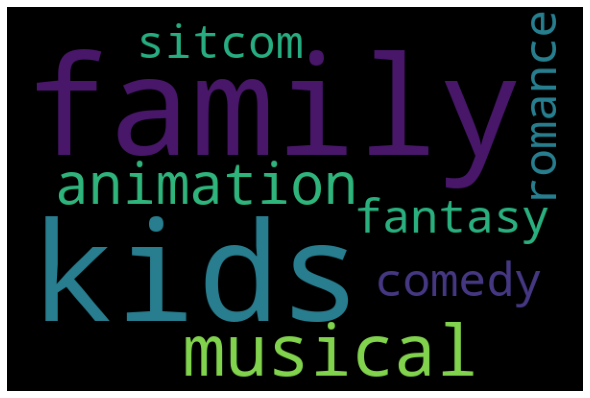

In [22]:
#Trending Genre in 20th century

comment_words = '' 
stopwords = set(STOPWORDS) 

lst = Trends['Trending genre based on ratingLevel'][:4].values.tolist() + Trends['Trending genre based on user rating score'][:4].values.tolist()

for val in lst: 
    val = str(val) 
    tokens = val.split() 

    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 600, height = 400, background_color ='black', stopwords = stopwords, min_font_size = 10).generate(comment_words) 
                       
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

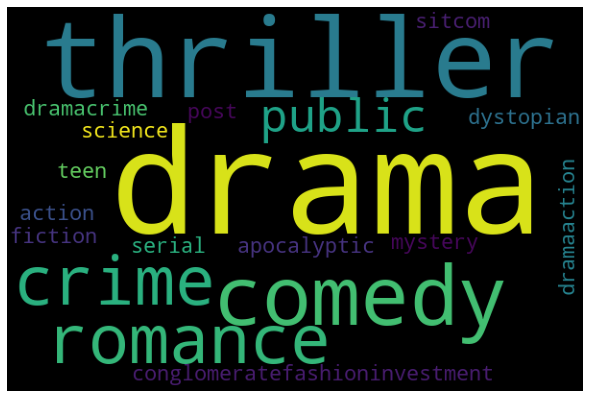

In [23]:
#Trending Genre for shows in 21st century

comment_words = '' 
stopwords = set(STOPWORDS) 
lst = Trends['Trending genre based on ratingLevel'][4:].values.tolist() + Trends['Trending genre based on user rating score'][4:].values.tolist()

for val in lst: 
    val = str(val) 
    tokens = val.split() 

    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 600, height = 400, background_color ='black', stopwords = stopwords, min_font_size = 10).generate(comment_words) 
                       
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

## Rating frequency overall

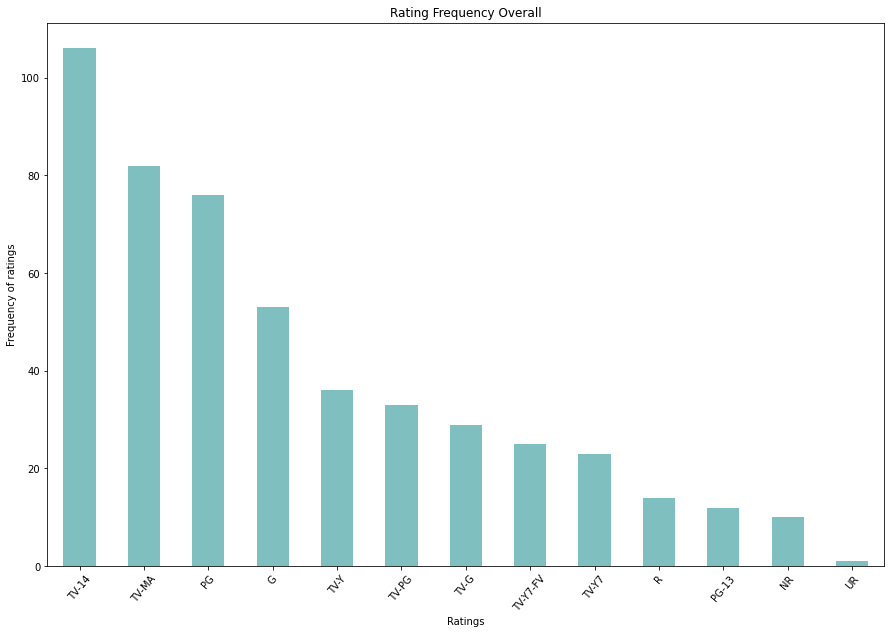

In [24]:
rating_freq = df2['rating'].value_counts()

plt.figure(figsize=(15,10))
rating_freq.plot.bar(color='teal',alpha=0.5)
plt.xticks(rotation=50)
plt.xlabel("Ratings")
plt.ylabel("Frequency of ratings")
plt.title("Rating Frequency Overall")
plt.show()
plt.close()

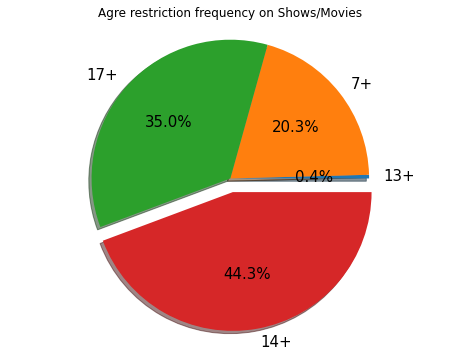

In [25]:
age_freq = df2['Age Restriction'].value_counts().sort_values(ascending= True)

fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot()
explode = (0, 0, 0, 0.1)
colors = np.arange(4)
ax.pie(age_freq.values, explode=explode,labels = age_freq.index,shadow=True,
autopct = '%1.1f%%',textprops = {'fontsize': 15, 'color' : "black"})
ax.set_title("Agre restriction frequency on Shows/Movies")
ax.axis('equal')
plt.show()

## Top shows/movies

In [26]:
df_top = df2[df2['user rating score']>0].dropna()
df_top = df_top.set_index(np.arange(0,121))
df_top

,Unnamed: 0,title,rating,ratingDescription,ratingLevel,release year,user rating score,user rating size,Genre,Age Restriction
0,2,Grey's Anatomy,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,98.0,80,"Medical drama, Romantic drama, Comedy-drama, E...",14+
1,3,Prison Break,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2008,98.0,80,Serial dramaCrime dramaAction thriller,14+
2,5,Supernatural,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,95.0,80,"Action, Adventure, Drama, Fantasy, Horror, Mys...",14+
3,6,Breaking Bad,TV-MA,For mature audiences. May not be suitable for...,110,2013,97.0,80,"Serial drama, Crime drama, Thriller, Neo-Weste...",17+
4,7,The Vampire Diaries,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2017,91.0,80,"Drama, Supernatural, Horror, Fantasy",14+
...,...,...,...,...,...,...,...,...,...,...
116,358,Lab Rats,TV-Y7,Suitable for children ages 7 and older,41,2016,85.0,80,"Comedy, Science fiction",7+
117,361,Dragons: Race to the Edge,TV-Y7-FV,Suitable for children ages 7 and older. Conte...,42,2017,88.0,80,AdventureFantasyComedy-drama,7+
118,365,Dawn of the Croods,TV-Y7,Suitable for children ages 7 and older,41,2017,72.0,80,ComedyAdventure,7+
119,405,The Real Ghostbusters,TV-Y7,Suitable for children ages 7 and older,41,1990,65.0,80,Animation,7+


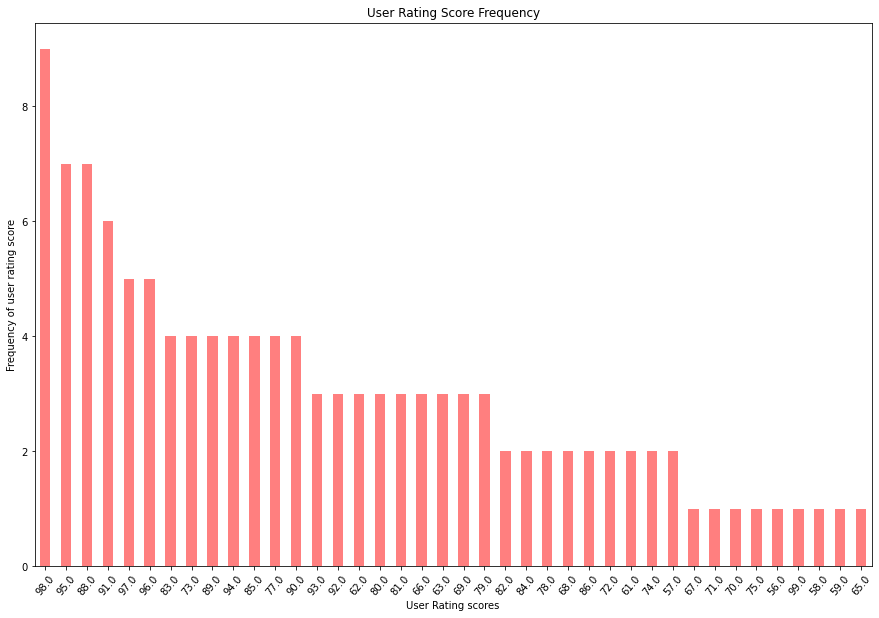

In [27]:
score_freq = df_top['user rating score'].value_counts()

plt.figure(figsize=(15,10))
score_freq.plot.bar(color='red', alpha=0.5)
plt.xticks(rotation=50)
plt.xlabel("User Rating scores")
plt.ylabel("Frequency of user rating score")
plt.title("User Rating Score Frequency")
plt.show()

In [28]:
df_top.sort_values("user rating score", axis = 0, ascending = False, inplace = True, na_position ='last')

In [29]:
uniq = df_top['user rating score'].unique()

In [30]:
year_freq = df2['release year'].value_counts().sort_values(ascending= True)
year_freq

1940      1
1986      1
1976      1
1978      1
1996      1
1987      1
1992      1
1991      1
1982      2
1990      2
1995      2
1989      2
1994      4
1999      5
1993      5
2002      5
2001      6
2004      7
2000      7
2007      8
1998      9
1997      9
2005     10
2006     10
2009     10
2003     11
2008     11
2010     13
2011     15
2012     27
2013     33
2014     35
2017     37
2015     61
2016    146
Name: release year, dtype: int64

## Total Shows/Movies released in each year

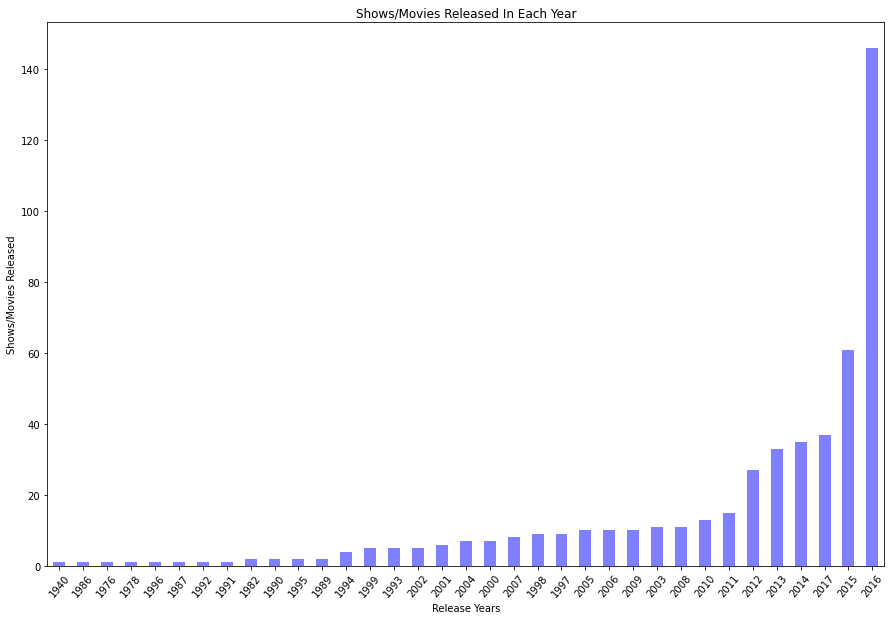

In [31]:
plt.figure(figsize=(15,10))
year_freq.plot.bar(color='blue', alpha=0.5)
plt.xticks(rotation=50)
plt.xlabel("Release Years")
plt.ylabel("Shows/Movies Released")
plt.title("Shows/Movies Released In Each Year")

plt.show()

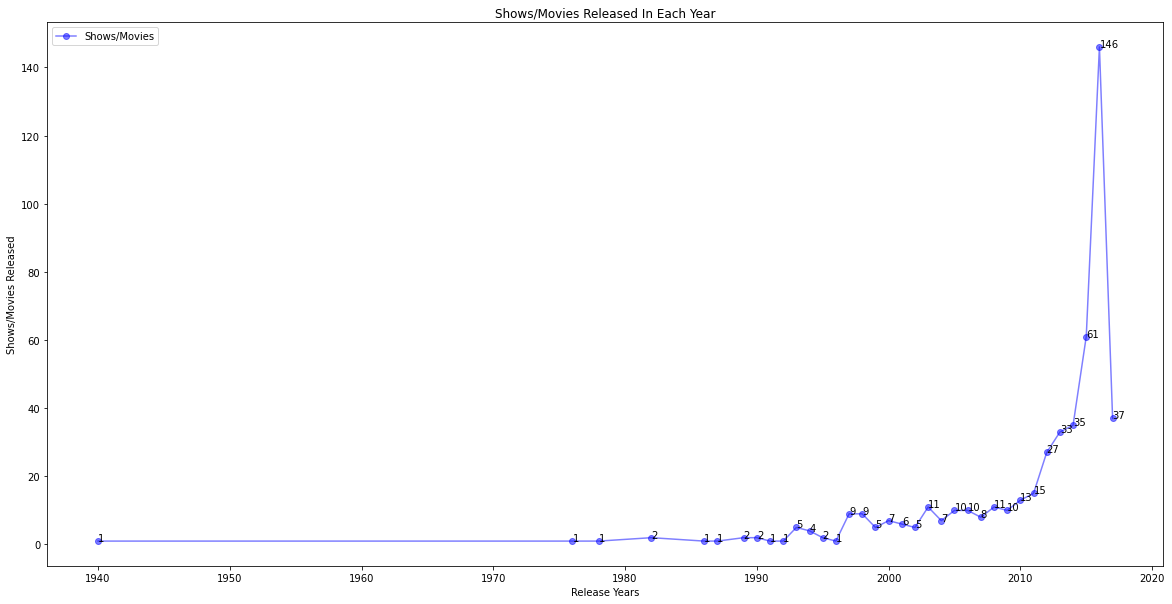

In [32]:
year_freq2 = df2['release year'].value_counts().sort_index(ascending= True)
fig = plt.figure(figsize = (20, 10))

ax2 = fig.add_subplot()
x = year_freq2.index
y = year_freq2.values
ax2.plot(x,y, marker='o', linestyle='-', color='b', 
label='Shows/Movies',alpha=0.5) 
ax2.set_xlabel('Release Years')
ax2.set_ylabel('Shows/Movies Released') 
ax2.set_title('Shows/Movies Released In Each Year')
ax2.legend(loc = "upper left") 

for a,b in zip(x, y): 
    plt.text(a, b, str(b))

plt.show()

## Frequency for rating level

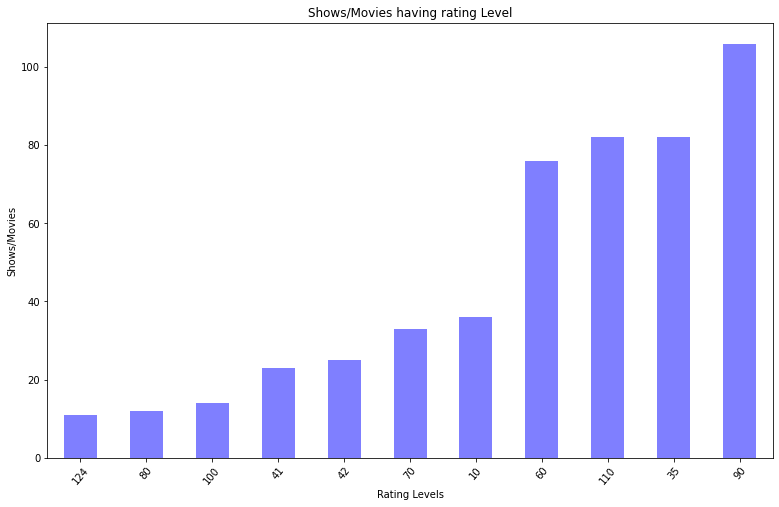

In [33]:
rl_freq = df2['ratingLevel'].value_counts().sort_values(ascending= True)

plt.figure(figsize=(13,8))
rl_freq.plot.bar(color='blue', alpha=0.5)
plt.xticks(rotation=50)
plt.xlabel("Rating Levels")
plt.ylabel("Shows/Movies")
plt.title("Shows/Movies having rating Level")

plt.show()

In [34]:
rating_ = df2['rating'].unique()
year_ = df2['release year'].unique()
year_.sort()
print("Rating unique : ", rating_)
print("year unique : ", year_)

Rating unique :  ['PG-13' 'R' 'TV-14' 'TV-PG' 'TV-MA' 'TV-Y' 'NR' 'TV-Y7-FV' 'UR' 'PG'
 'TV-G' 'G' 'TV-Y7']
year unique :  [1940 1976 1978 1982 1986 1987 1989 1990 1991 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017]


## Get frequency of each ratings every year 

In [35]:
c_list = []
rating_count_lst = []
final_c = 0

for i in range(len(year_)):
    for j in range(len(rating_)):
        count = 0
        for k in range(len(df['rating'])):
            if df2['rating'][k] == rating_[j] and df2['release year'][k] == year_[i]:
                count += 1
                final_c +=1
        c_list.append(count)
    rating_count_lst.append(c_list)
    c_list =[]   

print("rating freq in yeach year",rating_count_lst)
#print(series_rating)
print(len(rating_count_lst))
print(final_c)


rating freq in yeach year [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 2, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 1, 0, 3, 0, 3, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 3, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 5, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 2, 0], [1, 0, 1, 0, 0, 1, 0, 1, 0, 2, 1, 4, 0], [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0], [0, 0, 2, 1, 0, 0, 0, 1, 0, 3, 0, 3, 0], [2, 1, 2, 0, 0, 0, 0, 0, 0, 1,

## Count of ratings every year -- Create a DataFrame

In [36]:
each_year = pd.DataFrame(rating_count_lst,columns=rating_, index= year_) #Create a dataframe for the result obtained above
each_year

,PG-13,R,TV-14,TV-PG,TV-MA,TV-Y,NR,TV-Y7-FV,UR,PG,TV-G,G,TV-Y7
1940,0,0,0,0,0,0,0,0,0,0,0,1,0
1976,0,0,0,0,0,0,0,0,0,0,0,1,0
1978,0,0,0,0,0,0,0,0,0,1,0,0,0
1982,0,0,0,0,0,0,0,0,0,1,0,1,0
1986,0,0,0,0,0,0,0,0,0,0,0,1,0
1987,0,0,0,0,0,0,0,0,0,1,0,0,0
1989,0,0,0,0,0,0,0,0,0,1,0,0,1
1990,0,0,0,0,0,0,0,0,0,0,0,1,1
1991,0,0,0,0,0,0,0,0,0,0,0,1,0
1992,0,0,0,0,0,0,0,0,0,0,0,1,0


In [37]:
maxValues = each_year.idxmax(axis = 1) #Highest movie ratings each year 
print(maxValues) 

1940           G
1976           G
1978          PG
1982          PG
1986           G
1987          PG
1989          PG
1990           G
1991           G
1992           G
1993          PG
1994          PG
1995          PG
1996    TV-Y7-FV
1997          PG
1998          PG
1999           G
2000           G
2001           R
2002          PG
2003           G
2004           G
2005          PG
2006           G
2007          PG
2008       TV-PG
2009        TV-G
2010       TV-14
2011       TV-14
2012       TV-14
2013       TV-14
2014       TV-14
2015       TV-14
2016       TV-14
2017       TV-MA
dtype: object


In [38]:
rating_overall = maxValues.value_counts()
rating_overall

PG          12
G           11
TV-14        7
TV-MA        1
TV-PG        1
R            1
TV-G         1
TV-Y7-FV     1
dtype: int64

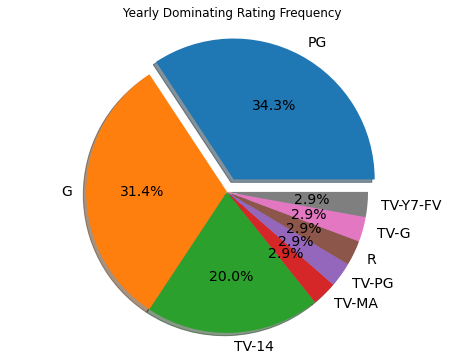

In [39]:
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot()
explode = (0.1, 0, 0, 0,0,0,0,0)
colors = np.arange(4)
ax.pie(rating_overall.values, explode=explode,labels = rating_overall.index,shadow=True,
autopct = '%1.1f%%',textprops = {'fontsize': 14, 'color' : "black"})
ax.set_title(" Yearly Dominating Rating Frequency")
ax.axis('equal')
plt.show()

## Heat Map for the DataFrame created above

Text(0.5, 1.0, 'Rating Frequency from 1940 To 2017')

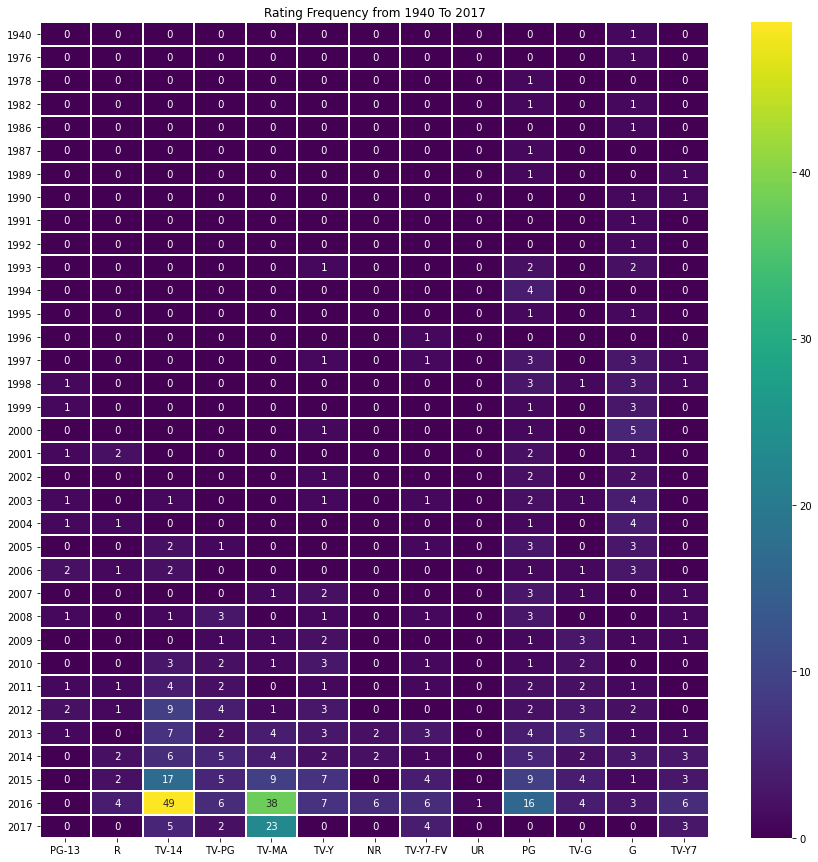

In [40]:
import seaborn as sns

plt.figure(figsize=(15,15))
sns.heatmap(each_year,linewidths=1,annot=True,fmt='2.0f',cmap="viridis")
plt.title('Rating Frequency from 1940 To 2017')

## Drop rows with neglegible values

In [41]:
year_df = each_year.drop(axis=0,index=[1940,1976,1978,1982,1987,1986,1989,1990]) 
year_df

,PG-13,R,TV-14,TV-PG,TV-MA,TV-Y,NR,TV-Y7-FV,UR,PG,TV-G,G,TV-Y7
1991,0,0,0,0,0,0,0,0,0,0,0,1,0
1992,0,0,0,0,0,0,0,0,0,0,0,1,0
1993,0,0,0,0,0,1,0,0,0,2,0,2,0
1994,0,0,0,0,0,0,0,0,0,4,0,0,0
1995,0,0,0,0,0,0,0,0,0,1,0,1,0
1996,0,0,0,0,0,0,0,1,0,0,0,0,0
1997,0,0,0,0,0,1,0,1,0,3,0,3,1
1998,1,0,0,0,0,0,0,0,0,3,1,3,1
1999,1,0,0,0,0,0,0,0,0,1,0,3,0
2000,0,0,0,0,0,1,0,0,0,1,0,5,0


## Visualization of Frequency of each ratings from 1990-2017

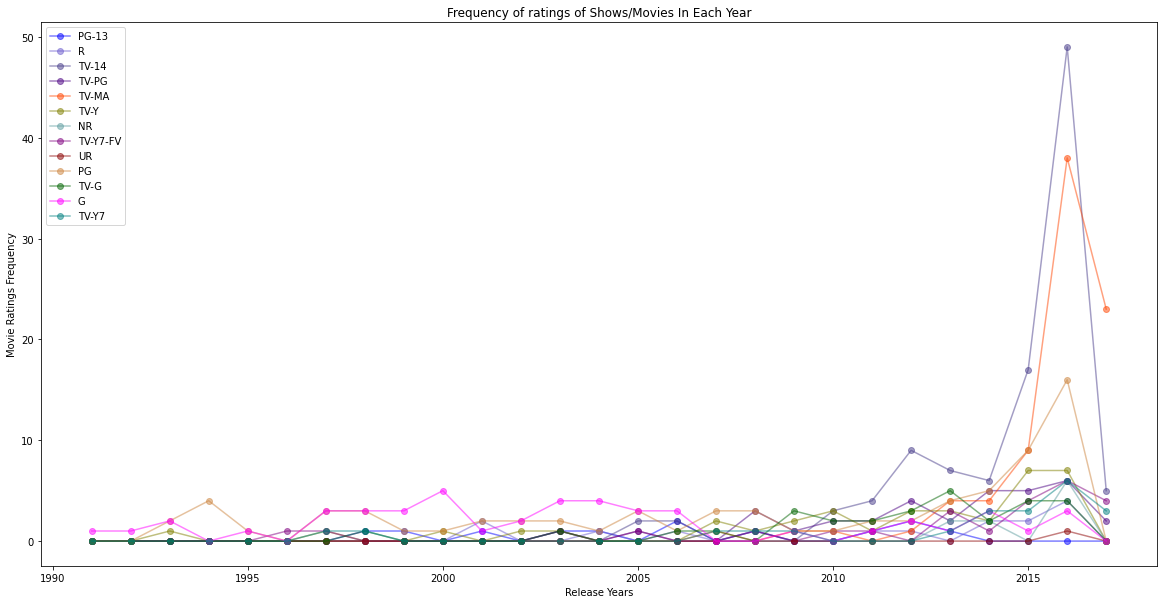

In [42]:
fig = plt.figure(figsize = (20, 10))
ax2 = fig.add_subplot()
x= year_df.index
c=['blue','slateblue','darkslateblue','indigo','orangered','olive','cadetblue','purple','darkred','peru','darkgreen','fuchsia','teal']

for i in range(len(rating_)):
    ax2.plot(x,year_df[rating_[i]], marker='o', linestyle='-', color=c[i], label=rating_[i],alpha =0.5) 

ax2.set_xlabel('Release Years')
ax2.set_ylabel('Movie Ratings Frequency') 
ax2.set_title('Frequency of ratings of Shows/Movies In Each Year')
ax2.legend(loc = "upper left") 


plt.show()

In [43]:
for i in range(len(df2['rating'])):
    if 'Suitable for all ages.' in df2['ratingDescription'][i]:
        df2['Age Restriction'][i] = 'No Restriction'

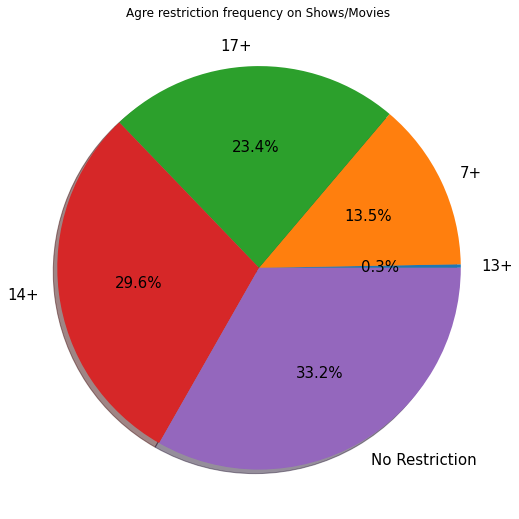

In [44]:
age_freq = df2['Age Restriction'].value_counts().sort_values(ascending= True)

fig = plt.figure(figsize = (8, 9))
ax = fig.add_subplot()
#explode = (0, 0, 0, 0.1)
colors = np.arange(4)
ax.pie(age_freq.values,labels = age_freq.index,shadow=True,
autopct = '%1.1f%%',textprops = {'fontsize': 15, 'color' : "black"})
ax.set_title("Agre restriction frequency on Shows/Movies")
ax.axis('equal')
plt.show()

In [45]:
df2[10:20]

,Unnamed: 0,title,rating,ratingDescription,ratingLevel,release year,user rating score,user rating size,Genre,Age Restriction
10,10,Once Upon a Time,TV-PG,Parental guidance suggested. May not be suitab...,70,2016,98.0,80,"Fantasy, Adventure, Drama",NaN
11,11,Sherlock,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,95.0,80,"Crime, Mystery, Comedy-drama",14+
12,12,Death Note,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2006,77.0,80,Anime&Manga,14+
13,13,Naruto,TV-PG,Parental guidance suggested. May not be suitab...,70,2008,88.0,80,Anime&Manga,NaN
14,14,The Hunter,R,language and brief violence,100,2011,NaN,82,"mystery,thriller",NaN
15,15,Lottie Dottie Chicken,TV-Y,Suitable for all ages.,10,2009,NaN,82,NaN,No Restriction
16,16,Arrow,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2015,96.0,80,"Superhero, Drama, Action, Crime, Mystery",14+
17,17,Black Mirror,TV-MA,For mature audiences. May not be suitable for...,110,2016,80.0,80,"Science fiction, Dystopia, Satire, Anthology, ...",17+
18,18,The Originals,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,74.0,80,"Horror, Fantasy, Supernatural",14+
19,19,The 100,NR,This movie has not been rated.,124,2016,97.0,80,"Action, Drama, Dystopian, Post-apocalyptic, Sc...",NaN


In [46]:
df_general_shows = df2[(df2['Age Restriction'] == 'No Restriction') & (df2['user rating score'] > 75)]
x = df_general_shows.shape[0] #rows
x

18

In [47]:
df_Mature_shows = df[(df['Age Restriction'] != 'no restriction') & (df['user rating score'] > 75)]
y = df_Mature_shows.shape[0] #rows
y

174

## Ratio of popularity for general vs Age restricted movies all together.

In [48]:
print("Ratio of popular general : mature movies/shows in netflix --> ",int(x/10), ":", int(y/10))

Ratio of popular general : mature movies/shows in netflix -->  1 : 17


In [49]:
df_top = df2[df2['user rating score']>0].dropna()
df_top = df_top.set_index(np.arange(0,145))
df_top

,Unnamed: 0,title,rating,ratingDescription,ratingLevel,release year,user rating score,user rating size,Genre,Age Restriction
0,2,Grey's Anatomy,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,98.0,80,"Medical drama, Romantic drama, Comedy-drama, E...",14+
1,3,Prison Break,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2008,98.0,80,Serial dramaCrime dramaAction thriller,14+
2,5,Supernatural,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,95.0,80,"Action, Adventure, Drama, Fantasy, Horror, Mys...",14+
3,6,Breaking Bad,TV-MA,For mature audiences. May not be suitable for...,110,2013,97.0,80,"Serial drama, Crime drama, Thriller, Neo-Weste...",17+
4,7,The Vampire Diaries,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2017,91.0,80,"Drama, Supernatural, Horror, Fantasy",14+
...,...,...,...,...,...,...,...,...,...,...
140,413,An American Tail,G,General Audiences. Suitable for all ages.,35,1986,67.0,80,"fantasy,kids,family,animation",No Restriction
141,417,Balto,G,General Audiences. Suitable for all ages.,35,1995,64.0,80,United States of America (Territory of Alaska),No Restriction
142,424,Brother Bear 2,G,General Audiences. Suitable for all ages.,35,2006,57.0,80,"kids,family,animation,adventure,comedy",No Restriction
143,431,Animaniacs,TV-Y7,Suitable for children ages 7 and older,41,1997,72.0,80,ComedyMusicalSatireSketchEducationalSlapstick,7+


## Words commonly used in Titles among popular Movies

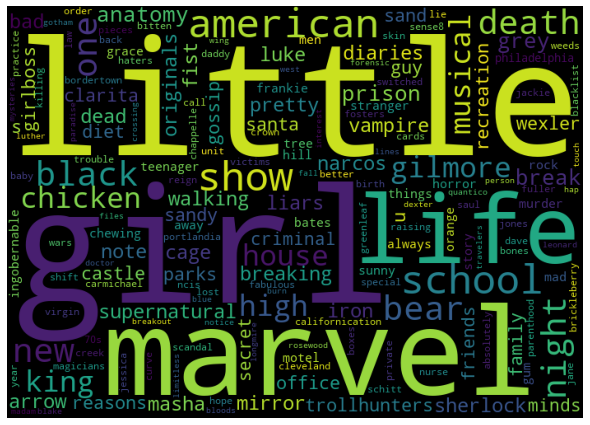

In [50]:
comment_words = '' 
stopwords = set(STOPWORDS) 
   
for val in df_top.title[:]: 
    val = str(val) 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 700, height = 500, background_color ='black', stopwords = stopwords, min_font_size = 10).generate(comment_words) 
                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

## Trending Genre overall

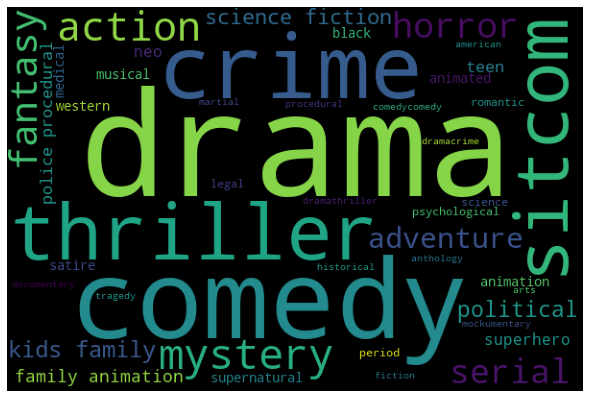

In [51]:
comment_words = '' 
stopwords = set(STOPWORDS) 

for val in df_top.Genre: 
    val = str(val) 
    tokens = val.split() 

    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 600, height = 400, background_color ='black', stopwords = stopwords, min_font_size = 10).generate(comment_words) 
                       
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

## Final dataset to CSV file

Final dataset with two additional columns, 'Genre' and 'Age Restriction'. 

In [52]:
df2.to_csv('500_Netflix_Shows.csv', index=False) 